In [1]:
import os
import cv2
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from deep_sort_realtime.deepsort_tracker import DeepSort

In [2]:
'''
Video Env Settings:
To match the simulation setup to the expert environment, the following parameters must be set consistently:
- area_width
- area_height
- max_turn
- prey_speed
- pred_speed
- step_size = 1, as each frame in the video corresponds to one simulation step
'''

'\nVideo Env Settings:\nTo match the simulation setup to the expert environment, the following parameters must be set consistently:\n- area_width\n- area_height\n- max_turn\n- prey_speed\n- pred_speed\n- step_size = 1, as each frame in the video corresponds to one simulation step\n'

In [ ]:
# paths
raw_video_folder = rf'..\data\1. Data Processing\raw\pred_prey_interaction' 
total_frames_folder = rf'..\data\1. Data Processing\processed\video\1. total_frames'
raw_video_path = rf'..\data\1. Data Processing\raw\pred_prey_interaction\pred_prey_interaction_0.07.mp4' 

In [4]:
# Area width and height
cap = cv2.VideoCapture(raw_video_path)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print("Area Width:", width)
print("Area Height:", height)

Area Width: 2160
Area Height: 2160


In [5]:
# Max Turn Analysis

# load init_pool
init_pool_path = rf"..\data\1. Data Processing\processed\init_pool\init_pool.pt"
init_pool = torch.load(init_pool_path)

# shape back to window structure to get consecutive frames
window, agents, coordinates = init_pool.shape  # [240, 33, 3]
window_len = 10
n_clips = window // window_len
clips = init_pool.view(n_clips, window_len, agents, coordinates)
thetas = clips[..., 2]

# compute angle differences
dtheta = thetas[:, 1:, :] - thetas[:, :-1, :]
dtheta_pi = (dtheta + torch.pi) % (2 * torch.pi) - torch.pi
abs_dtheta = dtheta_pi.abs().reshape(-1)

# compute quantiles
q95  = torch.quantile(abs_dtheta, 0.95).item()
q99  = torch.quantile(abs_dtheta, 0.99).item()
q999 = torch.quantile(abs_dtheta, 0.999).item()

print("95-Quantile:  ",  q95,  "radient |", q95*180/np.pi,  "degrees")
print("99-Quantile:  ",  q99,  "radient |", q99*180/np.pi,  "degrees")
print("99.9-Quantile:",  q999, "radient |", q999*180/np.pi, "degrees")

95-Quantile:   0.1292572021484375 radient | 7.405892154774786 degrees
99-Quantile:   0.3142143487930298 radient | 18.00315604829218 degrees
99.9-Quantile: 2.0950937271118164 radient | 120.0400282478405 degrees


In [ ]:
window_len = 10
window_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\windows\{window_len} windows'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pred_files = []
prey_files = []

# load expert tensors
for file in os.listdir(window_path):
    if file.startswith("pred"):
        pred_tensor = torch.load(os.path.join(window_path, file))
        pred_files.append(pred_tensor)
    elif file.startswith("prey"):
        prey_tensor = torch.load(os.path.join(window_path, file))
        prey_files.append(prey_tensor)

# concatenate all tensors
exp_pred_tensor = torch.cat(pred_files, dim=0).type(torch.float32)
exp_prey_tensor = torch.cat(prey_files, dim=0).type(torch.float32)

print("Pred Tensor Shape:", exp_pred_tensor.shape)
print("Prey Tensor Shape:", exp_prey_tensor.shape)

Pred Tensor Shape: torch.Size([793, 10, 1, 32, 5])
Prey Tensor Shape: torch.Size([793, 10, 32, 32, 6])


[PREDATOR]
Min: 0.0
Max: 0.9917646050453186
Mean: 0.49103013939927687


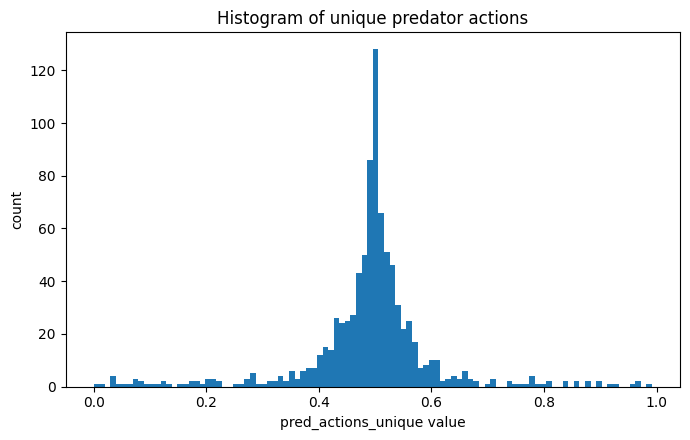

In [ ]:
# get unique predator actions
pred_actions = exp_pred_tensor[..., 4]
pred_actions_unique = list(set(pred_actions.reshape(-1).tolist()))

print("[PREDATOR]")
print("Min:", min(pred_actions_unique))
print("Max:", max(pred_actions_unique))
print("Mean:", sum(pred_actions_unique)/len(pred_actions_unique))

# plot histogram of unique predator actions
plt.figure(figsize=(7,4.5))
plt.hist(pred_actions_unique, bins=100)
plt.xlabel("pred_actions_unique value")
plt.ylabel("count")
plt.title("Histogram of unique predator actions")
plt.tight_layout()
plt.show()

[PREY]
Min: 0.0
Max: 0.9999999403953552
Mean: 0.49745246124809533


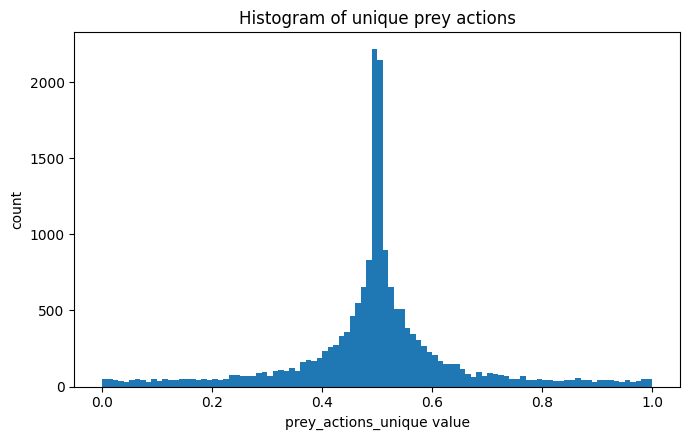

In [ ]:
# get unique prey actions
prey_actions = exp_prey_tensor[..., 5]
prey_actions_unique = list(set(prey_actions.reshape(-1).tolist()))

print("[PREY]")
print("Min:", min(prey_actions_unique))
print("Max:", max(prey_actions_unique))
print("Mean:", sum(prey_actions_unique)/len(prey_actions_unique))

# plot histogram of unique prey actions
plt.figure(figsize=(7,4.5))
plt.hist(prey_actions_unique, bins=100)
plt.xlabel("prey_actions_unique value")
plt.ylabel("count")
plt.title("Histogram of unique prey actions")
plt.tight_layout()
plt.show()

Average Predator Speed: 0.748726681350902
Average Prey Speed: 2.1051460963222075


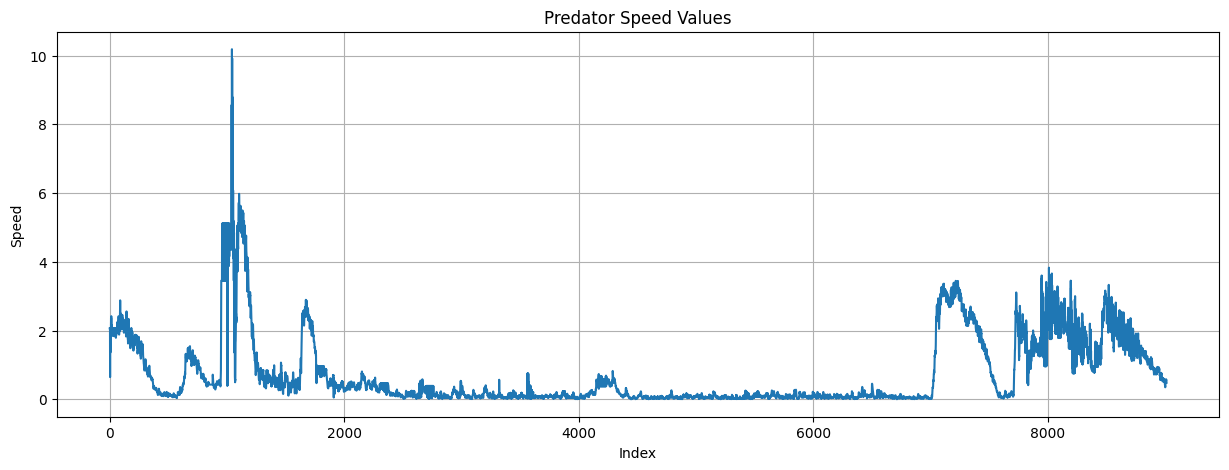

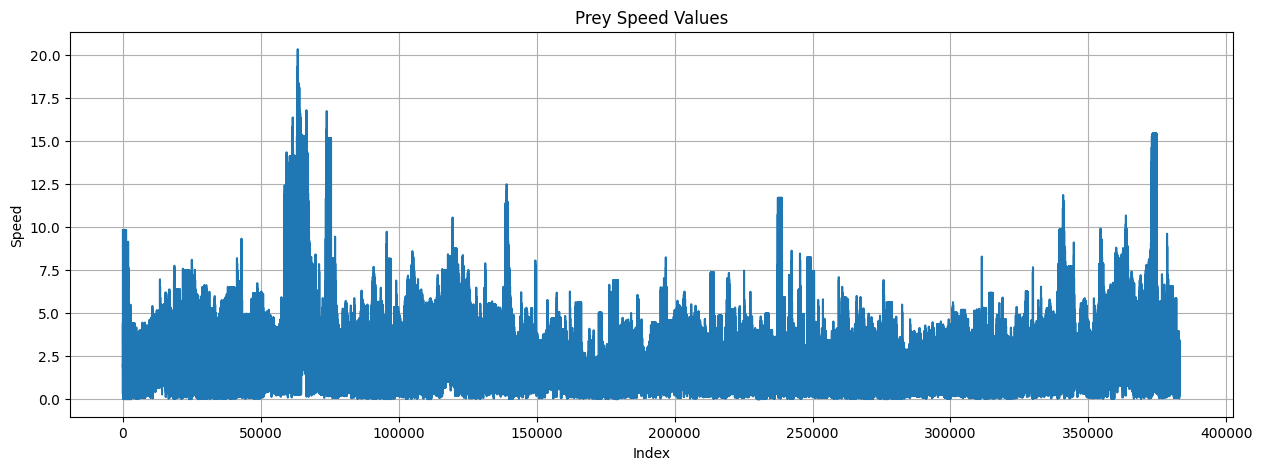

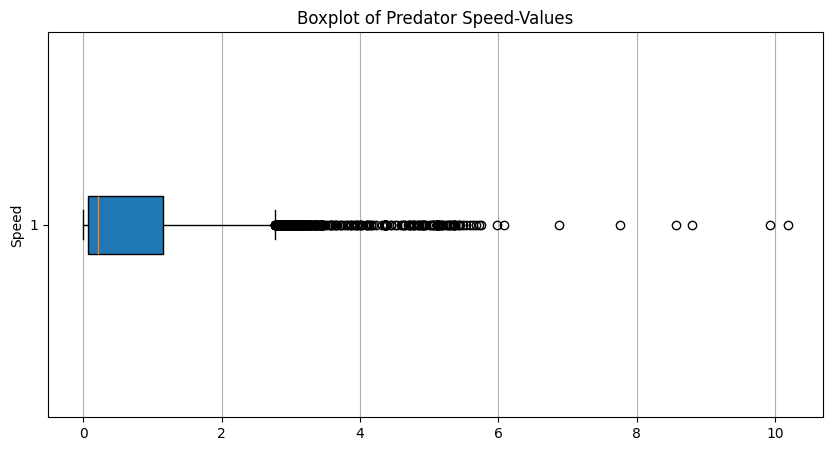

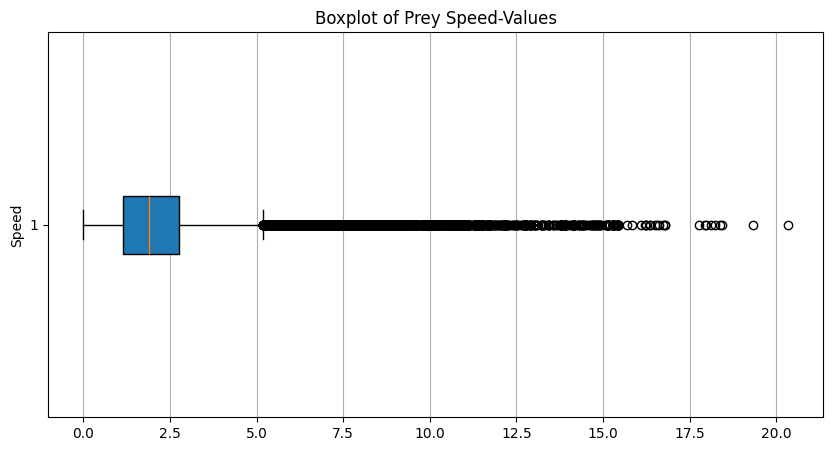

In [ ]:
# Speed Analysis
all_speeds = []
for video in os.listdir(raw_video_folder):
    # loop through total frames and collect speeds
    tf_path = os.path.join(total_frames_folder, f"total_frames_{video}.pkl")
    with open(tf_path, "rb") as f:
        total_frames = pickle.load(f)

    speeds = [det["speed"] for det in total_frames]
    all_speeds.extend(speeds)

# get predator speeds
total_frames_predator = [rec for rec in total_frames if str(rec["label"]) == "1"]
pred_speeds = [det["speed"] for det in total_frames_predator]

# get prey speeds
total_frames_prey = [rec for rec in total_frames if str(rec["label"]) == "2"]
prey_speeds = [det["speed"] for det in total_frames_prey]

# print average speeds
print(f"Average Predator Speed: {np.mean(pred_speeds)}")
print(f"Average Prey Speed: {np.mean(prey_speeds)}")

# plot predator speeds
plt.figure(figsize=(15,5))
plt.plot(pred_speeds)
plt.title("Predator Speed Values")
plt.xlabel("Index")
plt.ylabel("Speed")
plt.grid(True)
plt.show()

# plot prey speeds
plt.figure(figsize=(15,5))
plt.plot(prey_speeds)
plt.title("Prey Speed Values")
plt.xlabel("Index")
plt.ylabel("Speed")
plt.grid(True)
plt.show()

# boxplot of predator speed values
plt.figure(figsize=(10,5))
plt.boxplot(pred_speeds, vert=False, patch_artist=True)
plt.title("Boxplot of Predator Speed-Values")
plt.ylabel("Speed")
plt.grid(True, axis='x')
plt.show()

# boxplot of prey speed values
plt.figure(figsize=(10,5))
plt.boxplot(prey_speeds, vert=False, patch_artist=True)
plt.title("Boxplot of Prey Speed-Values")
plt.ylabel("Speed")
plt.grid(True, axis='x')
plt.show()